In [1]:
import os
import pathlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as dsp
from scipy.linalg import toeplitz
from scipy.signal import lfilter, lfilter_zi

rst = np.random.RandomState(1)

In [3]:
from PyDynamic.model_estimation.fit_filter import invLSFIR_unc
from PyDynamic.misc.SecondOrderSystem import *
from PyDynamic.misc.filterstuff import kaiser_lowpass
from PyDynamic.misc.tools import make_semiposdef, trimOrPad

In [4]:
def legacy_FIRuncFilter(
    y, sigma_noise, theta, Utheta=None, shift=0, blow=None, kind="corr"
):
    """Uncertainty propagation for signal y and uncertain FIR filter theta

    A preceding FIR low-pass filter with coefficients `blow` can be provided optionally.

    Parameters
    ----------
    y : np.ndarray
        filter input signal
    sigma_noise : float or np.ndarray
        float: standard deviation of white noise in y
        1D-array: interpretation depends on kind
    theta : np.ndarray
        FIR filter coefficients
    Utheta : np.ndarray, optional
        covariance matrix associated with theta
        if the filter is fully certain, use `Utheta = None` (default) to make use of
        more efficient calculations. See also the comparison given in
        <examples/Digital filtering/FIRuncFilter_runtime_comparison.py>
    shift : int, optional
        time delay of filter output signal (in samples) (defaults to 0)
    blow : np.ndarray, optional
        optional FIR low-pass filter
    kind : string
        only meaningful in combination with sigma_noise a 1D numpy array
        "diag": point-wise standard uncertainties of non-stationary white noise
        "corr": single sided autocovariance of stationary (colored/correlated)
        noise (default)

    Returns
    -------
    x : np.ndarray
        FIR filter output signal
    ux : np.ndarray
        point-wise standard uncertainties associated with x


    References
    ----------

    * Elster and Link 2008 [Elster2008]_

    .. seealso:: :mod:`PyDynamic.deconvolution.fit_filter`

    """

    Ntheta = len(theta)  # FIR filter size

    # check which case of sigma_noise is necessary
    if isinstance(sigma_noise, float):
        sigma2 = sigma_noise ** 2

    elif isinstance(sigma_noise, np.ndarray) and len(sigma_noise.shape) == 1:
        if kind == "diag":
            sigma2 = sigma_noise ** 2
        elif kind == "corr":
            sigma2 = sigma_noise
        else:
            raise ValueError("unknown kind of sigma_noise")

    else:
        raise ValueError(
            f"FIRuncFilter: Uncertainty sigma_noise associated "
            f"with input signal is expected to be either a float or a 1D array but "
            f"is of shape {sigma_noise.shape}. Please check documentation for input "
            f"parameters sigma_noise and kind for more information."
        )

    if isinstance(
        blow, np.ndarray
    ):  # calculate low-pass filtered signal and propagate noise

        if isinstance(sigma2, float):
            Bcorr = np.correlate(blow, blow, "full")  # len(Bcorr) == 2*Ntheta - 1
            ycorr = (
                sigma2 * Bcorr[len(blow) - 1 :]
            )  # only the upper half of the correlation is needed

            # trim / pad to length Ntheta
            ycorr = trimOrPad(ycorr, Ntheta)
            Ulow = toeplitz(ycorr)

        elif isinstance(sigma2, np.ndarray):

            if kind == "diag":
                # [Leeuw1994](Covariance matrix of ARMA errors in closed form) can be
                # used, to derive this formula
                # The given "blow" corresponds to a MA(q)-process.
                # Going through the calculations of Leeuw, but assuming
                # that E(vv^T) is a diagonal matrix with non-identical elements,
                # the covariance matrix V becomes (see Leeuw:corollary1)
                # V = N * SP * N^T + M * S * M^T
                # N, M are defined as in the paper
                # and SP is the covariance of input-noise prior to the observed
                # time-interval (SP needs be available len(blow)-time steps into the
                # past. Here it is assumed, that SP is constant with the first value
                # of sigma2)

                # V needs to be extended to cover Ntheta-1 time steps more into the past
                sigma2_extended = np.append(sigma2[0] * np.ones((Ntheta - 1)), sigma2)

                N = toeplitz(blow[1:][::-1], np.zeros_like(sigma2_extended)).T
                M = toeplitz(
                    trimOrPad(blow, len(sigma2_extended)),
                    np.zeros_like(sigma2_extended),
                )
                SP = np.diag(sigma2[0] * np.ones_like(blow[1:]))
                S = np.diag(sigma2_extended)

                # Ulow is to be sliced from V, see below
                V = N.dot(SP).dot(N.T) + M.dot(S).dot(M.T)

            elif kind == "corr":

                # adjust the lengths sigma2 to fit blow and theta
                # this either crops (unused) information or appends zero-information
                # note1: this is the reason, why Ulow will have dimension
                # (Ntheta x Ntheta) without further ado

                # calculate Bcorr
                Bcorr = np.correlate(blow, blow, "full")

                # pad or crop length of sigma2, then reflect some part to the left and
                # invert the order
                # [0 1 2 3 4 5 6 7] --> [0 0 0 7 6 5 4 3 2 1 0 1 2 3]
                sigma2 = trimOrPad(sigma2, len(blow) + Ntheta - 1)
                sigma2_reflect = np.pad(sigma2, (len(blow) - 1, 0), mode="reflect")

                ycorr = np.correlate(
                    sigma2_reflect, Bcorr, mode="valid"
                )  # used convolve in a earlier version, should make no difference as
                # Bcorr is symmetric
                Ulow = toeplitz(ycorr)

        xlow, _ = lfilter(blow, 1.0, y, zi=y[0] * lfilter_zi(blow, 1.0))

    else:  # if blow is not provided
        if isinstance(sigma2, float):
            Ulow = np.eye(Ntheta) * sigma2

        elif isinstance(sigma2, np.ndarray):

            if kind == "diag":
                # V needs to be extended to cover Ntheta time steps more into the past
                sigma2_extended = np.append(sigma2[0] * np.ones((Ntheta - 1)), sigma2)

                # Ulow is to be sliced from V, see below
                V = np.diag(
                    sigma2_extended
                )  # this is not Ulow, same thing as in the case of a provided blow
                # (see above)

            elif kind == "corr":
                Ulow = toeplitz(trimOrPad(sigma2, Ntheta))

        xlow = y

    # apply FIR filter to calculate best estimate in accordance with GUM
    x, _ = lfilter(theta, 1.0, xlow, zi=xlow[0] * lfilter_zi(theta, 1.0))
    x = np.roll(x, -int(shift))

    # add dimension to theta, otherwise transpose won't work
    if len(theta.shape) == 1:
        theta = theta[:, np.newaxis]

    # NOTE: In the code below wherever `theta` or `Utheta` get used, they need to be
    # flipped. This is necessary to take the time-order of both variables into
    # account. (Which is descending for `theta` and `Utheta` but ascending for `Ulow`.)
    #
    # Further details and illustrations showing the effect of not-flipping
    # can be found at https://github.com/PTB-M4D/PyDynamic/issues/183

    # handle diag-case, where Ulow needs to be sliced from V
    if kind == "diag":
        # UncCov needs to be calculated inside in its own for-loop
        # V has dimension (len(sigma2) + Ntheta) * (len(sigma2) + Ntheta) --> slice a
        # fitting Ulow of dimension (Ntheta x Ntheta)
        UncCov = np.zeros((len(sigma2)))

        if isinstance(Utheta, np.ndarray):
            for k in range(len(sigma2)):
                Ulow = V[k : k + Ntheta, k : k + Ntheta]
                UncCov[k] = np.squeeze(
                    np.flip(theta).T.dot(Ulow.dot(np.flip(theta)))
                    + np.abs(np.trace(Ulow.dot(np.flip(Utheta))))
                )  # static part of uncertainty
        else:
            for k in range(len(sigma2)):
                Ulow = V[k : k + Ntheta, k : k + Ntheta]
                UncCov[k] = np.squeeze(
                    np.flip(theta).T.dot(Ulow.dot(np.flip(theta)))
                )  # static part of uncertainty

    else:
        if isinstance(Utheta, np.ndarray):
            UncCov = np.flip(theta).T.dot(Ulow.dot(np.flip(theta))) + np.abs(
                np.trace(Ulow.dot(np.flip(Utheta)))
            )  # static part of uncertainty
        else:
            UncCov = np.flip(theta).T.dot(
                Ulow.dot(np.flip(theta))
            )  # static part of uncertainty

    if isinstance(Utheta, np.ndarray):
        unc = np.empty_like(y)

        # use extended signal to match assumption of stationary signal prior to first
        # entry
        xlow_extended = np.append(np.full(Ntheta - 1, xlow[0]), xlow)

        for m in range(len(xlow)):
            # extract necessary part from input signal
            XL = xlow_extended[m : m + Ntheta, np.newaxis]
            unc[m] = XL.T.dot(np.flip(Utheta).dot(XL))  # apply formula from paper
    else:
        unc = np.zeros_like(y)

    ux = np.sqrt(np.abs(UncCov + unc))
    ux = np.roll(ux, -int(shift))  # correct for delay

    return x, ux.flatten()  # flatten in case that we still have 2D array

In [5]:
# parameters of simulated measurement
Fs = 500e3
Ts = 1 / Fs

# sensor/measurement system
f0 = 36e3
uf0 = 0.01 * f0
S0 = 0.4
uS0 = 0.001 * S0
delta = 0.01
udelta = 0.1 * delta

# transform continuous system to digital filter
bc, ac = sos_phys2filter(S0, delta, f0)
b, a = dsp.bilinear(bc, ac, Fs)

# Monte Carlo for calculation of unc. assoc. with [real(H),imag(H)]
f = np.linspace(0, 120e3, 200)
Hfc = sos_FreqResp(S0, delta, f0, f)
Hf = dsp.freqz(b, a, 2 * np.pi * f / Fs)[1]

runs = 10000
MCS0 = S0 + rst.randn(runs) * uS0
MCd = delta + rst.randn(runs) * udelta
MCf0 = f0 + rst.randn(runs) * uf0
HMC = np.zeros((runs, len(f)), dtype=complex)
for k in range(runs):
    bc_, ac_ = sos_phys2filter(MCS0[k], MCd[k], MCf0[k])
    b_, a_ = dsp.bilinear(bc_, ac_, Fs)
    HMC[k, :] = dsp.freqz(b_, a_, 2 * np.pi * f / Fs)[1]

H = np.r_[np.real(Hf), np.imag(Hf)]
uAbs = np.std(np.abs(HMC), axis=0)
uPhas = np.std(np.angle(HMC), axis=0)
UH = np.cov(np.hstack((np.real(HMC), np.imag(HMC))), rowvar=0)
UH = make_semiposdef(UH)

Text(0, 0.5, 'magnitude / au')

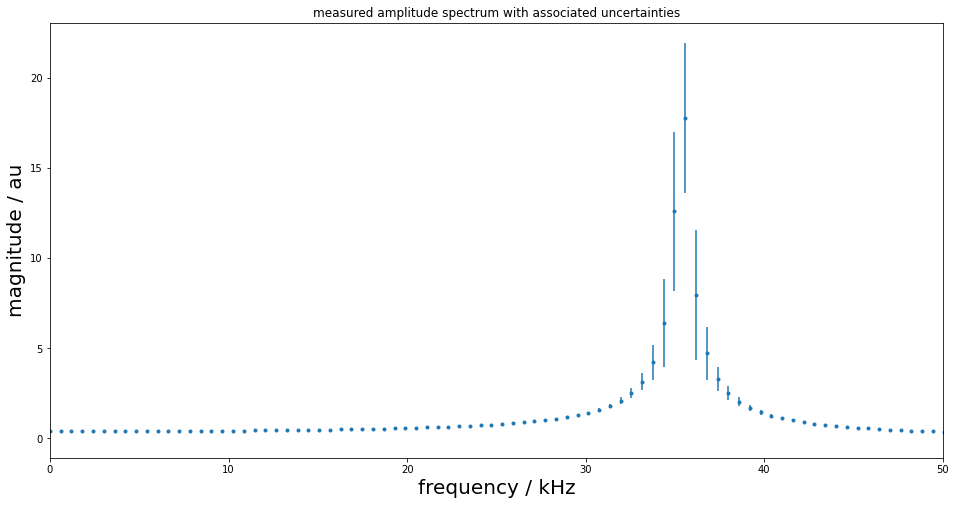

In [6]:
plt.figure(figsize=(16, 8))
plt.errorbar(f * 1e-3, np.abs(Hf), uAbs, fmt=".")
plt.title("measured amplitude spectrum with associated uncertainties")
plt.xlim(0, 50)
plt.xlabel("frequency / kHz", fontsize=20)
plt.ylabel("magnitude / au", fontsize=20)

Text(0, 0.5, 'phase / rad')

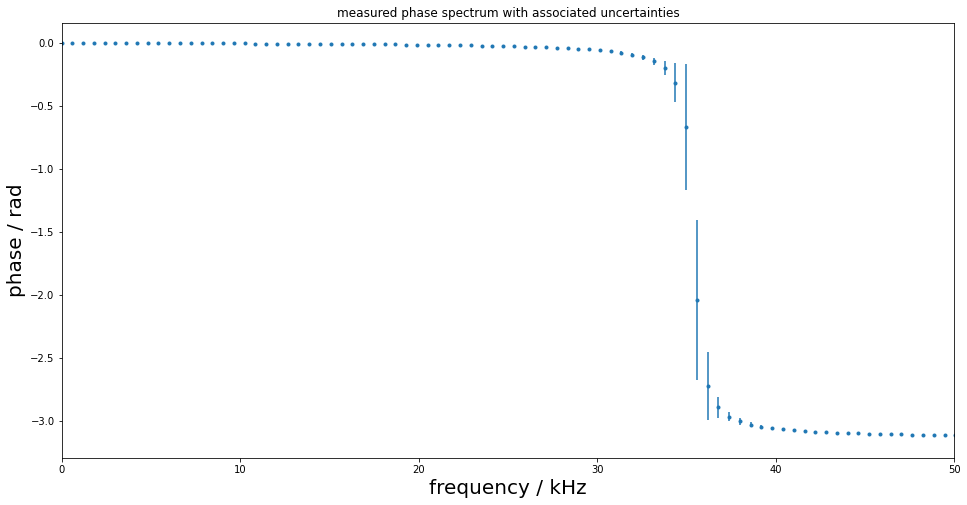

In [7]:
plt.figure(figsize=(16, 8))
plt.errorbar(f * 1e-3, np.angle(Hf), uPhas, fmt=".")
plt.title("measured phase spectrum with associated uncertainties")
plt.xlim(0, 50)
plt.xlabel("frequency / kHz", fontsize=20)
plt.ylabel("phase / rad", fontsize=20)

In [8]:
# simulate input and output signals
time = np.arange(0, 4e-3 - Ts, Ts)
# x = shocklikeGaussian(time, t0 = 2e-3, sigma = 1e-5, m0=0.8)
m0 = 0.8
sigma = 1e-5
t0 = 2e-3
x = (
    -m0
    * (time - t0)
    / sigma
    * np.exp(0.5)
    * np.exp(-((time - t0) ** 2) / (2 * sigma ** 2))
)
y = dsp.lfilter(b, a, x)
noise = 1e-3
yn = y + rst.randn(np.size(y)) * noise

Text(0, 0.5, 'signal amplitude / $m/s^2$')

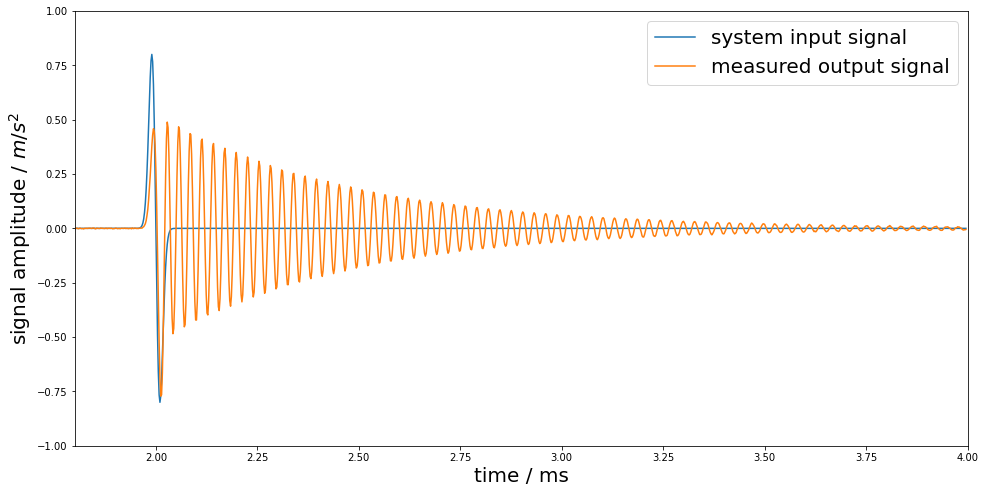

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(time * 1e3, x, label="system input signal")
plt.plot(time * 1e3, yn, label="measured output signal")
plt.legend(fontsize=20)
plt.xlim(1.8, 4)
plt.ylim(-1, 1)
plt.xlabel("time / ms", fontsize=20)
plt.ylabel(r"signal amplitude / $m/s^2$", fontsize=20)

In [10]:
# Calculation of FIR deconvolution filter and its assoc. unc.
N = 12
tau = N // 2
bF, UbF = invLSFIR_unc(H, UH, N, tau, f, Fs)


Least-squares fit of an order 12 digital FIR filter to the
reciprocal of a frequency response given by 400 values
and propagation of associated uncertainties.
Final rms error = 1.545423e+01 




Text(0, 0.5, 'FIR coefficient value')

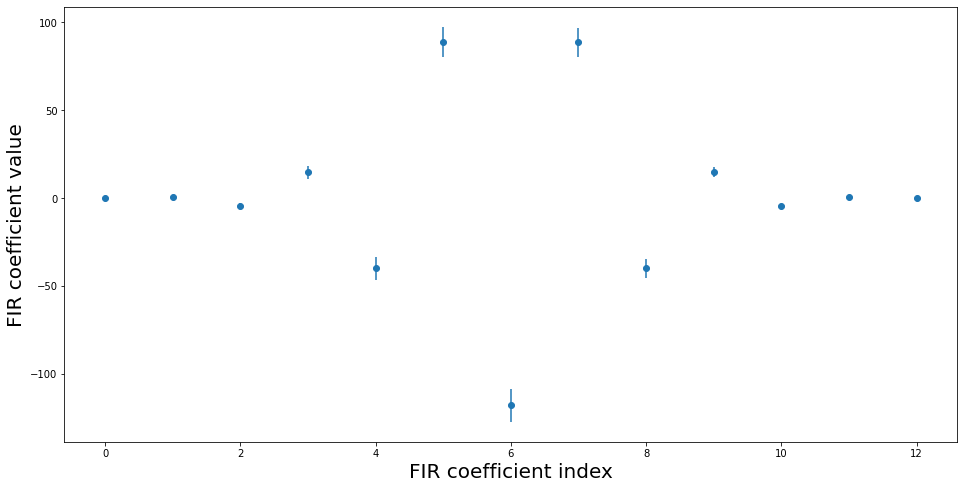

In [11]:
plt.figure(figsize=(16, 8))
plt.errorbar(range(N + 1), bF, np.sqrt(np.diag(UbF)), fmt="o")
plt.xlabel("FIR coefficient index", fontsize=20)
plt.ylabel("FIR coefficient value", fontsize=20)

In [12]:
fcut = f0 + 10e3
low_order = 100
blow, lshift = kaiser_lowpass(low_order, fcut, Fs)
shift = tau + lshift

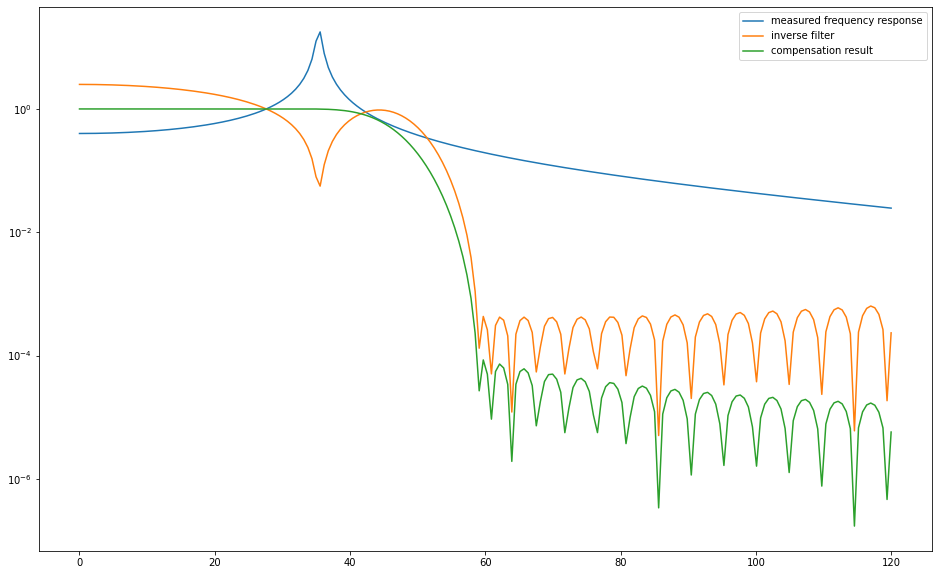

In [13]:
plt.figure(figsize=(16, 10))
HbF = (
    dsp.freqz(bF, 1, 2 * np.pi * f / Fs)[1] * dsp.freqz(blow, 1, 2 * np.pi * f / Fs)[1]
)
plt.semilogy(f * 1e-3, np.abs(Hf), label="measured frequency response")
plt.semilogy(f * 1e-3, np.abs(HbF), label="inverse filter")
plt.semilogy(f * 1e-3, np.abs(Hf * HbF), label="compensation result")
plt.legend()

In [14]:
xhat, Uxhat = legacy_FIRuncFilter(yn, noise, bF, UbF, shift, blow)

(-1.0, 1.0)

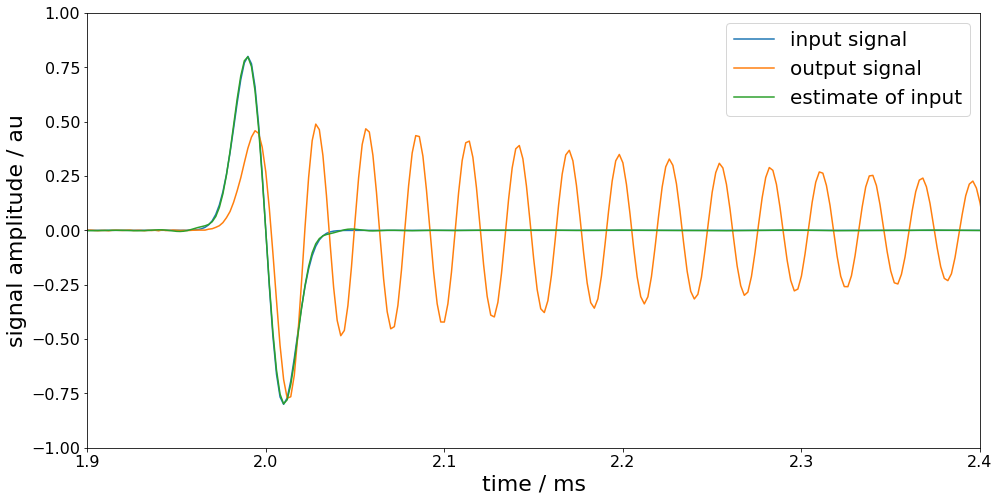

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(time * 1e3, x, label="input signal")
plt.plot(time * 1e3, yn, label="output signal")
plt.plot(time * 1e3, xhat, label="estimate of input")
plt.legend(fontsize=20)
plt.xlabel("time / ms", fontsize=22)
plt.ylabel("signal amplitude / au", fontsize=22)
plt.tick_params(which="both", labelsize=16)
plt.xlim(1.9, 2.4)
plt.ylim(-1, 1)

(1.9, 2.4)

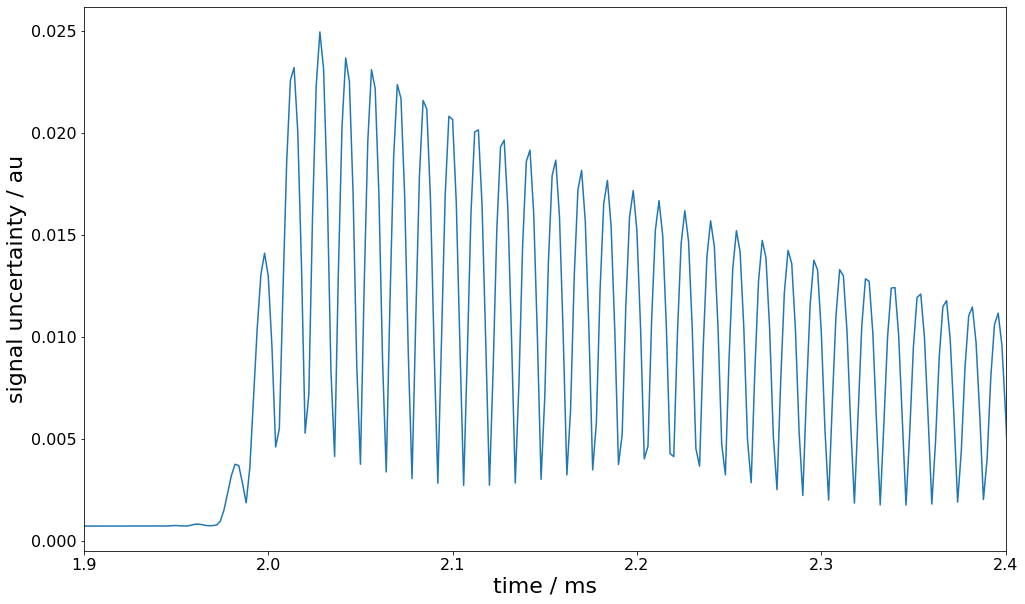

In [16]:
plt.figure(figsize=(16, 10))
plt.plot(time * 1e3, Uxhat)
plt.xlabel("time / ms", fontsize=22)
plt.ylabel("signal uncertainty / au", fontsize=22)
plt.subplots_adjust(left=0.15, right=0.95)
plt.tick_params(which="both", labelsize=16)
plt.xlim(1.9, 2.4)